### Este tem como objetivo principal carregar dados de um arquivo CSV, armazená-los em um banco de dados MongoDB, pré-processar os dados e usar SOMs para identificar padrões e possíveis casos suspeitos de inadimplência

In [2]:
# imports
from minisom import MiniSom
import pandas as pd
import numpy as np
from pylab import pcolor, colorbar, plot
from pymongo import MongoClient
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

import warnings

# Suprimir todos os warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Carregamento do CSV

- Carrega o arquivo CSV utilizando as bibliotecas apropriadas.
- Realiza uma análise inicial da estrutura dos dados com os seguintes métodos:
  - `head()`: Exibe as primeiras linhas do DataFrame.
  - `info()`: Mostra um resumo da estrutura do DataFrame.
  - `describe()`: Fornece estatísticas descritivas das colunas numéricas.


In [3]:
# Carregando os Dados
base = pd.read_csv('./data/credit_data.csv')

In [4]:
base.head()

,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       1997 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


In [6]:
base.shape

(2000, 5)

In [7]:
base.describe()

,clientid,income,age,loan,default
count,2000.000000,2000.000000,1997.000000,2000.000000,2000.000000
mean,1000.500000,45331.600018,40.807559,4444.369695,0.141500
std,577.494589,14326.327119,13.624469,3045.410024,0.348624
min,1.000000,20014.489470,-52.423280,1.377630,0.000000
25%,500.750000,32796.459717,28.990415,1939.708847,0.000000
50%,1000.500000,45789.117313,41.317159,3974.719419,0.000000
75%,1500.250000,57791.281668,52.587040,6432.410625,0.000000
max,2000.000000,69995.685578,63.971796,13766.051239,1.000000


In [8]:
def validate_data(df):
    """
    Valida os dados antes de armazená-los.
    """
    issues = []

    # Verifica valores negativos
    if (df['age'] < 0).any():
        issues.append("Existem valores negativos na coluna 'age'.")
    
    # Verifica valores nulos
    if df.isnull().sum().sum() > 0:
        issues.append("Existem valores ausentes no DataFrame.")
    
    # Verifica se o tipo de dado está correto
    expected_types = {
        'clientid': (int, np.int64),
        'income': (float, np.float64),
        'age': (float, np.float64),
        'loan': (float, np.float64),
        'default': (int, np.int64)
    }

    for column, valid_types in expected_types.items():
        if not isinstance(df[column].dtype.type(), valid_types):
            issues.append(f"A coluna '{column}' não está no tipo esperado ({valid_types}).")
    
    # Retorna resultados
    if issues:
        raise ValueError(f"Erros de validação encontrados: {', '.join(issues)}")
    else:
        print("Validação concluída com sucesso.")



In [9]:
# Validação dos Dados
try:
    validate_data(base)
except ValueError as e:
    print(e)
    exit(1)

Erros de validação encontrados: Existem valores negativos na coluna 'age'., Existem valores ausentes no DataFrame.


In [10]:
# Tratando os Dados
base.loc[base['age'] < 0, 'age'] = base['age'].mean()
base = base.dropna()

In [11]:
# Validação dos Dados
try:
    validate_data(base)
except ValueError as e:
    print(e)
    exit(1)

Validação concluída com sucesso.


In [12]:
base.columns

Index(['clientid', 'income', 'age', 'loan', 'default'], dtype='object')

## Conexão e Manipulação no MongoDB

### Função `connection_database`
- Estabelece uma conexão com o MongoDB e retorna uma coleção específica.
- Limpa o banco anterior para evitar conflitos entre os dados.

### Inserção de Registros
- Converte o DataFrame em formato de dicionário.
- Insere os dados na coleção do MongoDB.

### Exibição de Registros
- Recupera os registros armazenados na coleção.
- Exibe os dados para validação e análise.


In [13]:
def connection_database(host, port, name_db, name_collection):
    try:
        client = MongoClient(host, port, serverSelectionTimeoutMS=5000)
        # Verifica conexão com o servidor
        client.server_info()
        client.drop_database(name_db)  # Limpa o banco
        db = client[name_db]
        collection = db[name_collection]
        print("Conexão bem-sucedida com o banco de dados.")
        return collection
    except Exception as e:
        raise ConnectionError(f"Erro ao conectar ao banco de dados: {e}")

In [14]:
# Conexão com MongoDB
try:
    collection = connection_database('localhost', 27017, 'financas', 'operacoes')
except ConnectionError as e:
    print(e)
    exit(1)

Conexão bem-sucedida com o banco de dados.


In [15]:
# Inserção de Dados
try:
    data = base.to_dict(orient='records')
    collection.insert_many(data)
    print("Registros inseridos com sucesso no MongoDB.")
except Exception as e:
    print(f"Erro ao inserir registros no MongoDB: {e}")
    exit(1)


Registros inseridos com sucesso no MongoDB.


In [16]:
def view_records_paginated(collection, page_size=10):
    """
    Exibe registros do MongoDB com paginação.
    :param collection: Coleção do MongoDB.
    :param page_size: Número de registros por página.
    """
    try:
        total_records = collection.count_documents({})
        print(f"Total de registros: {total_records}")
        
        # Controle de páginas
        for skip in range(0, total_records, page_size):
            print(f"\nPágina {skip // page_size + 1}:")
            records = collection.find().skip(skip).limit(page_size)
            for record in records:
                print(record)
                
            # Pausa para o usuário navegar entre as páginas
            user_input = input("\nPressione Enter para continuar para a próxima página ou digite 'exit' para sair...")
            if user_input.lower() == 'exit':
                print("Execução interrompida pelo usuário.")
                break
    except Exception as e:
        print(f"Erro ao exibir registros paginados: {e}")


In [17]:
# Chamada para exibir registros com paginação
view_records_paginated(collection, page_size=20)

Total de registros: 1997

Página 1:
{'_id': ObjectId('676767ab7c3fd35b3a02348d'), 'clientid': 1, 'income': 66155.9250950813, 'age': 59.0170150669292, 'loan': 8106.53213128514, 'default': 0}
{'_id': ObjectId('676767ab7c3fd35b3a02348e'), 'clientid': 2, 'income': 34415.1539658196, 'age': 48.11715310486029, 'loan': 6564.745017677379, 'default': 0}
{'_id': ObjectId('676767ab7c3fd35b3a02348f'), 'clientid': 3, 'income': 57317.1700630337, 'age': 63.10804949188599, 'loan': 8020.953296386469, 'default': 0}
{'_id': ObjectId('676767ab7c3fd35b3a023490'), 'clientid': 4, 'income': 42709.534200839706, 'age': 45.7519723521546, 'loan': 6103.642260140699, 'default': 0}
{'_id': ObjectId('676767ab7c3fd35b3a023491'), 'clientid': 5, 'income': 66952.68884534019, 'age': 18.5843359269202, 'loan': 8770.09923520439, 'default': 1}
{'_id': ObjectId('676767ab7c3fd35b3a023492'), 'clientid': 6, 'income': 24904.0641402826, 'age': 57.4716071025468, 'loan': 15.498598437827198, 'default': 0}
{'_id': ObjectId('676767ab7c3f

## Pré-processamento dos Dados

### Limpeza dos Dados
- Remove valores inválidos, como idades negativas, substituindo-os pela média.
- Descarta valores ausentes utilizando o método `dropna()`.

### Separação de Variáveis
- Divide os dados em:
  - `X`: Variáveis independentes.
  - `y`: Variável alvo.

### Normalização
- Escala as variáveis independentes (`X`) para o intervalo `[0, 1]` utilizando o **MinMaxScaler**.


In [18]:
dados = list(collection.find())

# Criando o DataFrame
df = pd.DataFrame(dados)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   _id       1997 non-null   object 
 1   clientid  1997 non-null   int64  
 2   income    1997 non-null   float64
 3   age       1997 non-null   float64
 4   loan      1997 non-null   float64
 5   default   1997 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 93.7+ KB


In [20]:
df =df[['clientid', 'income', 'age', 'loan', 'default' ]]

In [21]:
df.isna().sum()

clientid    0
income      0
age         0
loan        0
default     0
dtype: int64

In [22]:
len(df)

1997

In [23]:
df['age'].describe()

count    1997.000000
mean       40.927520
std        13.261826
min        18.055189
25%        29.072097
50%        41.317159
75%        52.587040
max        63.971796
Name: age, dtype: float64

In [24]:
df['age'].median()

41.3171591130085

In [25]:
len(df)

1997

In [26]:
def normalize_data(X):
    try:
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_normalized = scaler.fit_transform(X)
        return X_normalized, scaler
    except Exception as e:
        raise ValueError(f"Erro durante a normalização dos dados: {e}")


In [27]:
# Normalização dos Dados
try:
    X, y = df.iloc[:, 0:4].values, df.iloc[:, 4].values
    X_normalized, scaler = normalize_data(X)
except ValueError as e:
    print(e)
    exit(1)

## Treinamento SOM

### Inicialização
- Cria um **Self-Organizing Map (SOM)** com dimensões `15x15`.
- Inicializa os pesos de forma aleatória.

### Treinamento
- Treina o SOM utilizando os dados normalizados.

### Visualização
- Plota o mapa de distâncias (`distance map`) para identificar regiões de similaridade.
- Marca os clusters no mapa com base na variável alvo para facilitar a interpretação.


In [30]:
som = MiniSom(x = 15, y = 15, input_len = 4, random_seed = 0)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

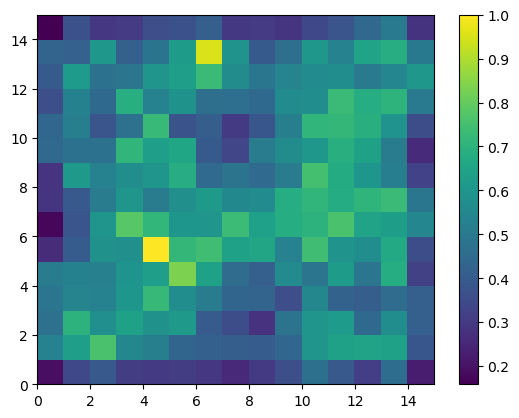

In [31]:
pcolor(som.distance_map().T)
colorbar()


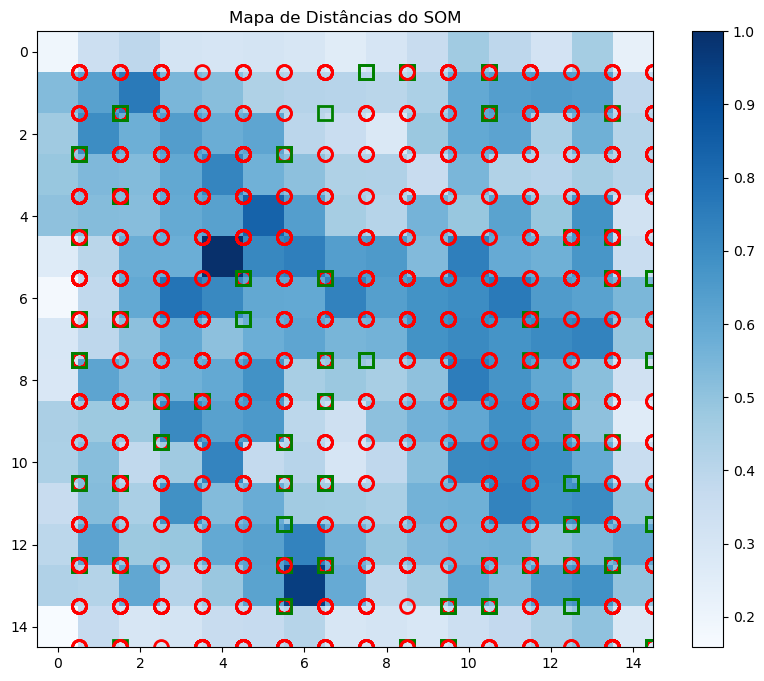

In [32]:
# Visualização do mapa de distâncias do SOM
def plot_som(som, X, y):
    plt.figure(figsize=(10, 8))
    
    # Mapa de distâncias
    plt.subplot(1, 1, 1)
    plt.title("Mapa de Distâncias do SOM")
    plt.imshow(som.distance_map().T, cmap='Blues')  # Mapa de distâncias usando colormap 'Blues'
    plt.colorbar()

    # Marcação dos pontos no mapa com cores diferentes para classes
    markers = ['o', 's']
    colors = ['r', 'g']
    
    for i, x in enumerate(X):
        w = som.winner(x)
        plt.plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]], 
                 markerfacecolor='None', markersize=10, 
                 markeredgecolor=colors[y[i]], markeredgewidth=2)
    
    plt.show()

# Chamada para exibir o gráfico
plot_som(som, X, y)

## Identificação de Suspeitos

### Identificação de Clusters
- Analisa padrões suspeitos em células específicas do SOM para agrupar comportamentos similares.

### Reconstrução e Classificação
- **Denormaliza os dados** para restaurar os valores originais.
- Associa os valores às respectivas classes (ex.: `default`).
- Ordena os resultados para priorizar os casos mais críticos.
- Cria o conjunto final de suspeitos para análise detalhada.


In [33]:
mapeamento = som.win_map(X)
suspeitos = np.concatenate((mapeamento[(13,9)], mapeamento[(1,10)]), axis = 0)
suspeitos = normalizador.inverse_transform(suspeitos)

In [34]:
classe = []
for i in range(len(base)):
    for j in range(len(suspeitos)):
       if base.iloc[i, 0] == int(round(suspeitos[j,0])):
           classe.append(base.iloc[i,4])
classe = np.asarray(classe)


In [35]:
suspeitos_final = np.column_stack((suspeitos, classe))
suspeitos_final = suspeitos_final[suspeitos_final[:, 4].argsort()]

In [36]:
suspeitos_final

array([[1.01000000e+02, 5.14610532e+04, 3.66515586e+01, 7.29226418e+03,
        0.00000000e+00],
       [3.13000000e+02, 5.14550985e+04, 3.72856837e+01, 9.44711716e+03,
        0.00000000e+00],
       [1.05500000e+03, 2.48207925e+04, 3.82440169e+01, 5.19492428e+01,
        0.00000000e+00],
       [1.16400000e+03, 3.09611661e+04, 3.21142866e+01, 1.62795596e+02,
        0.00000000e+00],
       [1.17200000e+03, 3.00372031e+04, 3.86849202e+01, 1.24701279e+03,
        0.00000000e+00],
       [1.20000000e+03, 2.62675294e+04, 3.44963862e+01, 5.94691634e+01,
        0.00000000e+00],
       [1.21500000e+03, 2.68671083e+04, 3.26222996e+01, 1.73015191e+03,
        0.00000000e+00],
       [1.24800000e+03, 3.17227309e+04, 3.48518173e+01, 2.87775610e+03,
        0.00000000e+00],
       [1.32200000e+03, 3.69703604e+04, 3.37045991e+01, 1.26850638e+03,
        0.00000000e+00],
       [1.37400000e+03, 3.13968660e+04, 3.49966814e+01, 3.71923013e+03,
        0.00000000e+00],
       [1.54000000e+03, 3.6455

In [37]:
# Salvando os resultados dos suspeitos em um arquivo CSV
suspeitos_final_df = pd.DataFrame(suspeitos_final, columns=['clientid', 'income', 'age', 'loan', 'default'])
suspeitos_final_df.to_csv('suspeitos.csv', index=False)

print("Resultados dos suspeitos salvos em 'suspeitos.csv'.")

Resultados dos suspeitos salvos em 'suspeitos.csv'.


In [38]:
# Criando um gráfico interativo de dispersão
def plot_suspeitos_interativo(suspeitos_final):
    suspeitos_df = pd.DataFrame(suspeitos_final, columns=['clientid', 'income', 'age', 'loan', 'default'])
    
    # Gráfico de dispersão interativo
    fig = px.scatter(suspeitos_df, x='age', y='income', color='default', 
                     labels={'default': 'Classe (0: Não suspeito, 1: Suspeito)'},
                     title="Dispersão dos Suspeitos")
    
    fig.update_layout(
        xaxis_title="Idade",
        yaxis_title="Renda",
        legend_title="Classe",
        template="plotly_dark"  # Usando tema dark para o gráfico
    )
    
    fig.show()



In [39]:
# Chamada para exibir o gráfico interativo
plot_suspeitos_interativo(suspeitos_final)

In [40]:
app = dash.Dash(__name__)

# Convertendo os suspeitos para DataFrame
suspeitos_df = pd.DataFrame(suspeitos_final, columns=['clientid', 'income', 'age', 'loan', 'default'])

# Criando o gráfico de dispersão com Plotly
fig = px.scatter(suspeitos_df, x='age', y='income', color='default', 
                 labels={'default': 'Classe (0: Não suspeito, 1: Suspeito)'},
                 title="Dispersão dos Suspeitos")

# Configurando o tema dark para o gráfico
fig.update_layout(
    template="plotly_dark",  # Aplica o tema dark do Plotly
    xaxis_title="Idade",
    yaxis_title="Renda",
    legend_title="Classe",
)

# Layout do dashboard com tema dark para a página inteira
app.layout = html.Div(style={'backgroundColor': '#333', 'color': 'white', 'padding': '20px', 'height': '100vh'}, children=[
    html.H1("Dashboard de Análise de Suspeitos", style={'textAlign': 'center', 'color': 'white'}),
    dcc.Graph(figure=fig)
])

In [41]:
### http://127.0.0.1:8050/

# Rodando o app
if __name__ == '__main__':
    app.run_server(debug=False)